# AIMS CDT Signal Processing Lab Session 4
## Gaussian Processes on Graphs
Xiaowen Dong (xdong@robots.ox.ac.uk), Yin-Cong Zhi (yin-cong.zhi@ndph.ox.ac.uk)
## Introduction

Acknowlegement: This lab session was first created by Yin-Cong Zhi in the Machine Learning Research Group in the Department of Engineering Science at Oxford University.

In this lab, we will be looking into Gaussian processes (GPs) on graphs. GPs are Bayesian non-parametric models, and they have unique properties in being able to predict with uncertainty, and generally performing better when there are less training data. In terms of machine learning on graphs, GPs are effective alternatives to GNNs on smaller graphs and can sometimes outperform them.

GPs can be implemented using GPyTorch or Pyro. For graph-based GPs, we will however use a more convenient package called `gpflow`: this is a tensorflow based library, therefore this lab will be make use of Tensorflow where appropriate. Compared to GNNs, GPs are generally slower to train, so we recommend running this in Colab, and change runtime type to (T4) GPU.

GPflow: https://www.gpflow.org/ <br>
GPyTorch: https://gpytorch.ai/ <br>
Pyro for GPs: https://pyro.ai/examples/gp.html

In [1]:
!pip install gpflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 118.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 2.0.0
    Uninstalling wrapt-2.0.0:
      Successfully uninstalled wrapt-2.0.0
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 

In [2]:
!python -c "import torch; print(torch.__version__)"

2.8.0+cu126


In [3]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv torch_geometric -f https://data.pyg.org/whl/torch-2.8.0+cu126.html

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 4, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/main.py", line 11, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/build_env.py", line 19, in <module>
    from pip._internal.cli.spinners import open_spinner
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/spinners.py", line 9, in <module>
^C


In [1]:
# Import required packages.
import numpy as np
import pandas as pd
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import ToUndirected

We will continue to work with the Cora citation dataset from Lab 3.

In [2]:
dataset = Planetoid(root='data/', name='cora', pre_transform=ToUndirected())
print('Feature dimension:', dataset.data.x.size(1))
print('Number of nodes:', dataset.data.x.size(0))
print('Number of classes:', dataset.data.y.max().numpy()+1)

Processing...


Feature dimension: 1433
Number of nodes: 2708
Number of classes: 7


Done!


In [3]:
# data loading
import tensorflow as tf
import gpflow
from gpflow.utilities import positive, print_summary

train_x = tf.convert_to_tensor(dataset.data.x[dataset.train_mask], tf.float64)
train_y = dataset.data.y.float()[dataset.train_mask]
val_x = tf.convert_to_tensor(dataset.data.x[dataset.val_mask], tf.float64)
val_y = dataset.data.y.float()[dataset.val_mask]
test_x = tf.convert_to_tensor(dataset.data.x[dataset.test_mask], tf.float64)
test_y = dataset.data.y.float()[dataset.test_mask]
num_classes = 7

# graph construction
from torch_geometric.utils import to_networkx
G = to_networkx(dataset.data, node_attrs=['y'], to_undirected=True)
L = nx.normalized_laplacian_matrix(G).todense()

## A Brief Overview of Gaussian Processes

A GP is a collection of random variables any finite subset of which has a joint Gaussian distribution. It can be conceptually viewed as an infinite dimensional function, and when defined on any finite set of points these will have a multivariate Gaussian distribution. Assuming a Gaussian process on some input data $\mathbf{x}_1, \dots, \mathbf{x}_N$ is equivalent to setting a Gaussian prior on the data, such that $\mathbf{f} = [f(\mathbf{x}_1), \dots, f(\mathbf{x}_N)]^\top$ has the following distribution

$$
\mathbf{f} \sim N(0, \mathbf{K}),
$$

with the predictive model taking the form

$$
y_i = f(\mathbf{x}_i) + \epsilon_i.
$$

The key element is the covariance matrix $\mathbf{K} \in \mathbb{R}^{N \times N}$ with $\mathbf{K}_{ij} = k(\mathbf{x}_i, \mathbf{x}_j)$ specified by a positive-definite kernel function $k(\cdot, \cdot)$. Choosing the kernel is therefore the most central element of model selection, as this fully specifies the prior and how the model makes prediction on unknown points. A common choice (on non-graph data) is the squared exponential (RBF) kernel:

$$
k_{\text{RBF}}(\mathbf{x}, \mathbf{x}') = \sigma^2 \exp\Big(-\frac{\|\mathbf{x}-\mathbf{x}'\|^2}{2l^2}\Big),
$$

where $\sigma^2$ is the variance to fit towards the magnitude of the data, $l$ is the lengthscale controlling the similarity between points, the interpretation being the larger lengthscale the more similar the predictions $f(\mathbf{x})$ and $f(\mathbf{x}')$ will be (and vice versa).

In building a GP on graphs, we will need to implement a kernel on graphs (more later).

In Bayesian modelling, we predict with a distribution. Let $f_* = f(\mathbf{x}_{test})$ denote our model on a novel test point, then we are interested in obtaining the predictive distribution

$$
P(f_* | D) = \int P(f_* | \mathbf{f}) P(\mathbf{f}| D) d\mathbf{f}
$$

with

$$
P(\mathbf{f}|D) \propto P(D|\mathbf{f})P(\mathbf{f}),
$$

with $P(\mathbf{f})$ being our chosen prior.

In the regression case, we assume a Gaussian likelihood

$$
P(D|\mathbf{f}) = \prod_{i=1}^N N(y_i | f(\mathbf{x}_i), \sigma_i^2)
$$

and everything in the integral is tractable, leading to a closed-form solution to the preditive distribution

$$
P(f_* | D) \sim N(\mu_*, \Sigma_*)
$$

with

$$
\mu_* = \mathbf{K}_*^\top\big(\mathbf{K} + \sigma_n^2 \mathbf{I}\big)^{-1}\mathbf{y}\\
\Sigma_* = \mathbf{K}_{**} - \mathbf{K}_{*}^\top\big(\mathbf{K} + \sigma^2 \mathbf{I}\big)^{-1}\mathbf{K}_*.
$$

Here $\mu_*$ is used for a point prediction, and $\Sigma_*$ is used to produce confidence intervals (the detailed derivation is omitted here but can be found in various textbooks and online resources).

In this lab, we are using GPs for multiclass classification, which assumes a more complex likelihood. This is explained as follows. Nodes in the Cora graph take 1 of 7 possible classes (from 0 to 6). For GPs, the labels are one-hot encoded: for instance if $y=2$, we convert this into $(0,0,1,0,0,0,0)^\top$. We then use 7 independent GPs to predict the likelihood of $y$ being in each of the 7 classes, combining them with the following density

$$
\pi_c(\mathbf{f}) = \begin{cases}
1 - \epsilon, & \text{if } c = \arg\max_{c'} f_{c'} \\
\frac{\epsilon}{C-1}, & \text{otherwise}
\end{cases}
$$

for $\mathbf{f} = (\mathbf{f}_1, \dots, \mathbf{f}_C)$, where $\epsilon$ is taken to be a small value (usually $10^{-3}$). The likelihood $P(\mathbf{f}|D)$ is then written as

$$
\prod_{i=1}^N \prod_{c=1}^C \pi(\mathbf{f}_c (\mathbf{x}_i))^{y_c}.
$$

This is called the robust maximum likelihood function: it is used in Gaussian processes instead of the softmax for numerical stability, and it also performs better generally.

This, however, makes computing the predictive distribution $P(f_* | D)$ intractable as the integral involves non-Gaussian terms, leading to the need for variational inference. Variational inference uses surrogate GPs - $q(\mathbf{f})$ - to approximate the shape of the non-Gaussian parts of the integral - $P(\mathbf{f}| D)$. In this case we need 7 separate surrogates for each class. Let $q(\mathbf{f}) = (q_1(\mathbf{f}_1), \dots, q_C(\mathbf{f}_C))$ consists of the 7 GPs, each with its own mean and covariance

$$
q_c(\mathbf{f}_c) \sim N(\mathbf{m}_c, \mathbf{S}_c\mathbf{S}_c^\top).
$$

Here $\mathbf{m}_c$ is a vector, and $\mathbf{S}_c$ is a lower triangular matrix. All terms in $\mathbf{m}_c$ and $\mathbf{S}_c$ are free parameters learned during model training by minimizing the KL divergence

$$
KL(q(\mathbf{f}) || p(\mathbf{f}|D)),
$$

which is equivalent to maximising the evidence lower bound (ELBO). Note, in classification, confidence intervals are not as useful, but it is important to know that they still exist, and can be interpreted as how certain the model is of the predictions.

The theories on GPs for classification are rather comprehensive, so we will refer readers to the [Gaussian Process for Machine Learning](https://gaussianprocess.org/gpml/chapters/RW.pdf) book for more detail.

## Implementing a Standard GP

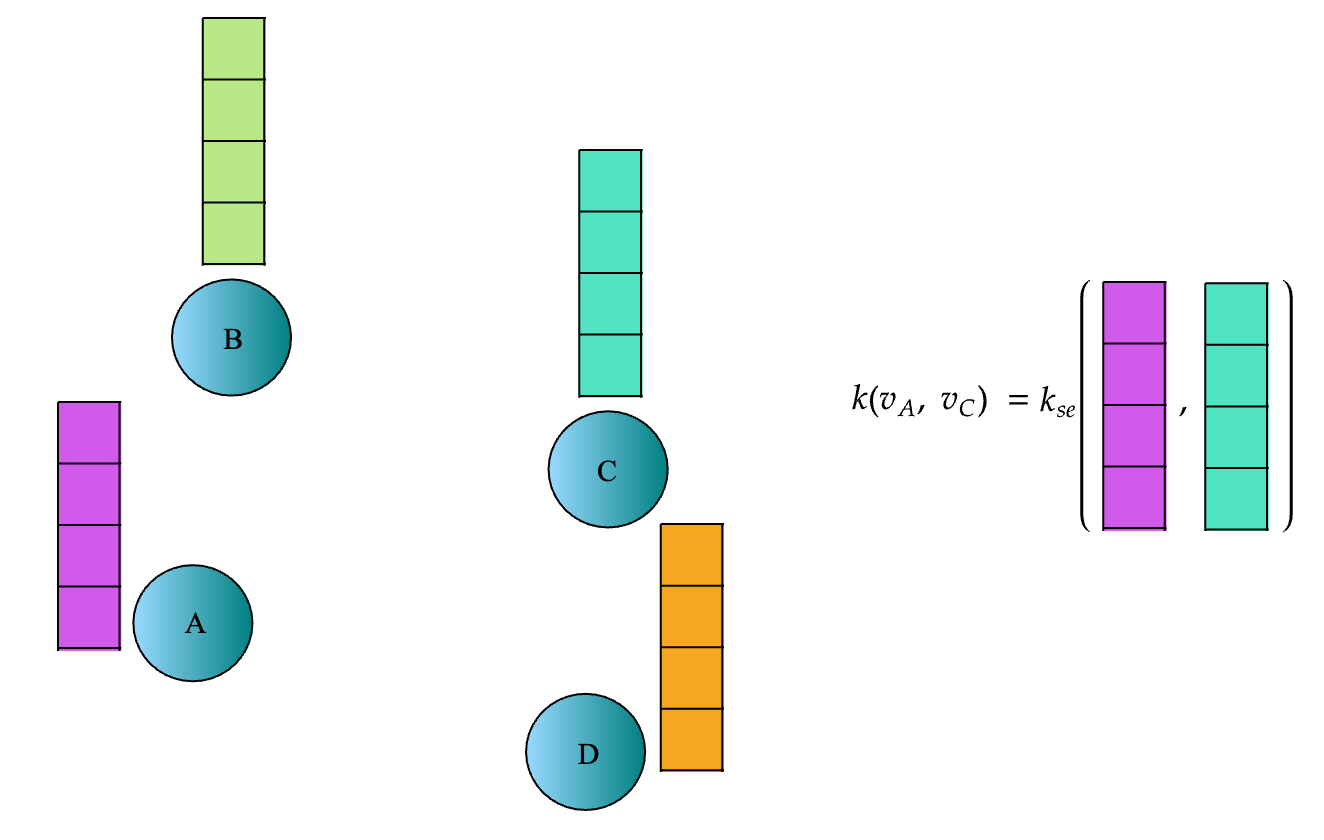

We will start by building a GP that train on just the node features, ignoring the graph. First thing to do when specifying a GP is to choose a kernel function, by specifying the prior in `gpflow`.

In [4]:
kernel = gpflow.kernels.SquaredExponential(lengthscales = 1., variance = 1.)

Other options include
- `gpflow.kernels.Polynomial(offset = 1., variance = 1.)`
- `gpflow.kernels.Matern12(lengthscales = 1., variance = 1.)`
- `gpflow.kernels.Matern32(lengthscales = 1., variance = 1.)`
- `gpflow.kernels.Matern52(lengthscales = 1., variance = 1.)`

`gpflow` also implements the robust maximum likelihood function.

In [5]:
invlink = gpflow.likelihoods.RobustMax(num_classes)
likelihood = gpflow.likelihoods.MultiClass(
    num_classes, invlink=invlink
)

Here, we will build a simple variational GP (VGP). Note, `gpflow` will automatically one-hot encode the labels, but you need to specify the number of latent (surrogate) GPs for the variational distribution (`num_latent_gps`) corresponding to the number of classes. All variational distributions and prediction are implemented within `gpflow`.

In [6]:
data = (train_x, train_y.reshape(-1,1))
model = gpflow.models.VGP(
    data=data,
    kernel=kernel,
    likelihood=likelihood,
    num_latent_gps=num_classes
)
print_summary(model, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[0., 0., 0...."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[1., 0., 0...."


During model training, to inspect the model at each epoch `gpflow` utilizes a `step_callback` function, and the one that we will use for this lab is provided below. Like Lab 3, we will mainly evaluate on the validation set.

In [7]:
def step_callback(step, variables=None, values=None):
    pred = model.predict_y(val_x)[0]
    pred_class = tf.argmax(pred, axis=1)
    val_acc = tf.reduce_sum(tf.cast(pred_class == val_y, tf.float64)).numpy()/len(val_y)
    print(f"Epoch {step}, ELBo = {model.elbo().numpy():.3f}, Val Acc = {val_acc}")
    if step % 10 == 0:
        print_summary(model, fmt="notebook")

Model training involves learning the optimal kernel parameters and variational distribution parameters, which are collectively called GP hyperparameters.

In [8]:
def optimize_tf(model, step_callback, lr=0.1, num_epoch=100):
    opt = tf.optimizers.Adam(learning_rate=lr)
    for epoch_idx in range(num_epoch):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(model.trainable_variables)
            loss = model.training_loss()
            gradients = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(gradients, model.trainable_variables))
        step_callback(epoch_idx)

optimize_tf(model, step_callback, lr=0.1, num_epoch=100)

Epoch 0, ELBo = -974.949, Val Acc = 0.258


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.9999999998141058
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-0.09999822, -0.09999822, -0.09999819..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[9.00001917e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 1, ELBo = -1048.984, Val Acc = 0.252
Epoch 2, ELBo = -870.436, Val Acc = 0.26
Epoch 3, ELBo = -917.070, Val Acc = 0.262
Epoch 4, ELBo = -898.364, Val Acc = 0.258
Epoch 5, ELBo = -814.696, Val Acc = 0.256
Epoch 6, ELBo = -777.354, Val Acc = 0.256
Epoch 7, ELBo = -787.476, Val Acc = 0.256
Epoch 8, ELBo = -774.985, Val Acc = 0.256
Epoch 9, ELBo = -720.484, Val Acc = 0.256
Epoch 10, ELBo = -662.634, Val Acc = 0.26


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.03404
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.09887
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-0.50711214, -0.50436296, -0.48535645..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[8.44336383e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 11, ELBo = -635.431, Val Acc = 0.262
Epoch 12, ELBo = -623.808, Val Acc = 0.262
Epoch 13, ELBo = -593.178, Val Acc = 0.262
Epoch 14, ELBo = -546.574, Val Acc = 0.268
Epoch 15, ELBo = -511.010, Val Acc = 0.268
Epoch 16, ELBo = -489.889, Val Acc = 0.276
Epoch 17, ELBo = -473.153, Val Acc = 0.282
Epoch 18, ELBo = -454.431, Val Acc = 0.282
Epoch 19, ELBo = -439.422, Val Acc = 0.316
Epoch 20, ELBo = -441.679, Val Acc = 0.328


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.22648
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.64334
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-0.26086196, -0.23560713, -0.17950887..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[8.03942018e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 21, ELBo = -456.983, Val Acc = 0.352
Epoch 22, ELBo = -474.272, Val Acc = 0.388
Epoch 23, ELBo = -482.209, Val Acc = 0.416
Epoch 24, ELBo = -478.906, Val Acc = 0.44
Epoch 25, ELBo = -471.795, Val Acc = 0.48
Epoch 26, ELBo = -463.719, Val Acc = 0.506
Epoch 27, ELBo = -454.347, Val Acc = 0.524
Epoch 28, ELBo = -443.495, Val Acc = 0.536
Epoch 29, ELBo = -433.257, Val Acc = 0.534
Epoch 30, ELBo = -426.380, Val Acc = 0.534


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.60498
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,2.62024
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-2.47677833e-01, -3.03985482e-02, -5.47422856e-02..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[7.26523989e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 31, ELBo = -421.896, Val Acc = 0.536
Epoch 32, ELBo = -417.758, Val Acc = 0.53
Epoch 33, ELBo = -413.298, Val Acc = 0.534
Epoch 34, ELBo = -409.910, Val Acc = 0.532
Epoch 35, ELBo = -406.878, Val Acc = 0.53
Epoch 36, ELBo = -404.859, Val Acc = 0.534
Epoch 37, ELBo = -402.726, Val Acc = 0.536
Epoch 38, ELBo = -399.129, Val Acc = 0.538
Epoch 39, ELBo = -396.168, Val Acc = 0.546
Epoch 40, ELBo = -392.404, Val Acc = 0.534


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,2.56012
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,3.90392
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-4.40784159e-01, -2.03974456e-01, 1.14141901e-02..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[6.17596711e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 41, ELBo = -388.719, Val Acc = 0.546
Epoch 42, ELBo = -384.590, Val Acc = 0.55
Epoch 43, ELBo = -382.320, Val Acc = 0.538
Epoch 44, ELBo = -380.155, Val Acc = 0.544
Epoch 45, ELBo = -379.074, Val Acc = 0.55
Epoch 46, ELBo = -378.667, Val Acc = 0.526
Epoch 47, ELBo = -377.801, Val Acc = 0.542
Epoch 48, ELBo = -377.948, Val Acc = 0.54
Epoch 49, ELBo = -377.252, Val Acc = 0.532
Epoch 50, ELBo = -377.401, Val Acc = 0.548


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,3.81555
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,5.08109
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-4.16110001e-01, -2.25450075e-01, 2.24236269e-02..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[5.21235664e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 51, ELBo = -376.520, Val Acc = 0.544
Epoch 52, ELBo = -376.005, Val Acc = 0.538
Epoch 53, ELBo = -374.933, Val Acc = 0.548
Epoch 54, ELBo = -374.238, Val Acc = 0.542
Epoch 55, ELBo = -372.924, Val Acc = 0.562
Epoch 56, ELBo = -372.149, Val Acc = 0.54
Epoch 57, ELBo = -371.420, Val Acc = 0.546
Epoch 58, ELBo = -371.039, Val Acc = 0.564
Epoch 59, ELBo = -370.668, Val Acc = 0.544
Epoch 60, ELBo = -370.355, Val Acc = 0.544


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,5.00317
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,5.92466
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-4.05482971e-01, -2.18857644e-01, 2.01846993e-02..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[4.31967088e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 61, ELBo = -370.133, Val Acc = 0.56
Epoch 62, ELBo = -369.851, Val Acc = 0.544
Epoch 63, ELBo = -369.486, Val Acc = 0.55
Epoch 64, ELBo = -369.178, Val Acc = 0.554
Epoch 65, ELBo = -368.850, Val Acc = 0.546
Epoch 66, ELBo = -368.553, Val Acc = 0.552
Epoch 67, ELBo = -368.195, Val Acc = 0.55
Epoch 68, ELBo = -368.153, Val Acc = 0.55
Epoch 69, ELBo = -367.826, Val Acc = 0.552
Epoch 70, ELBo = -367.703, Val Acc = 0.55


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,6.03901
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,6.50913
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-3.84869168e-01, -1.85151880e-01, 1.35623661e-02..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[4.07117554e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 71, ELBo = -367.667, Val Acc = 0.552
Epoch 72, ELBo = -367.483, Val Acc = 0.552
Epoch 73, ELBo = -367.363, Val Acc = 0.548
Epoch 74, ELBo = -367.355, Val Acc = 0.554
Epoch 75, ELBo = -367.164, Val Acc = 0.558
Epoch 76, ELBo = -367.047, Val Acc = 0.546
Epoch 77, ELBo = -366.960, Val Acc = 0.556
Epoch 78, ELBo = -366.827, Val Acc = 0.55
Epoch 79, ELBo = -366.779, Val Acc = 0.546
Epoch 80, ELBo = -366.770, Val Acc = 0.55


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,6.90297
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,6.90941
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-3.49287126e-01, -1.55763177e-01, 1.26399117e-02..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[3.83926107e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 81, ELBo = -366.921, Val Acc = 0.548
Epoch 82, ELBo = -367.049, Val Acc = 0.548
Epoch 83, ELBo = -366.943, Val Acc = 0.556
Epoch 84, ELBo = -366.713, Val Acc = 0.546
Epoch 85, ELBo = -366.725, Val Acc = 0.546
Epoch 86, ELBo = -366.700, Val Acc = 0.556
Epoch 87, ELBo = -366.654, Val Acc = 0.554
Epoch 88, ELBo = -366.609, Val Acc = 0.542
Epoch 89, ELBo = -366.611, Val Acc = 0.56
Epoch 90, ELBo = -366.613, Val Acc = 0.536


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,7.6399
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,7.20201
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-3.27279845e-01, -1.29761821e-01, 1.34152378e-02..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[3.57163345e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 91, ELBo = -366.499, Val Acc = 0.556
Epoch 92, ELBo = -366.435, Val Acc = 0.548
Epoch 93, ELBo = -366.562, Val Acc = 0.546
Epoch 94, ELBo = -366.628, Val Acc = 0.558
Epoch 95, ELBo = -366.436, Val Acc = 0.546
Epoch 96, ELBo = -366.261, Val Acc = 0.552
Epoch 97, ELBo = -366.295, Val Acc = 0.556
Epoch 98, ELBo = -366.260, Val Acc = 0.54
Epoch 99, ELBo = -366.152, Val Acc = 0.556


In [9]:
# final prediction
pred = model.predict_y(val_x)
pred_class = tf.argmax(pred[0], axis=1)
tf.reduce_sum(tf.cast(pred_class == val_y, tf.float64)).numpy()/len(val_y)

0.556

- Can you describe what each parameter in the model summary does?

kernel variance: the overall vertical scale of the latent function. Larger → larger function outputs a priori.

kernel lengthscale: how quickly the function varies in input space (per input dimension or a scalar). Small lengthscale → quickly changing functions; large → smooth, slowly varying.

- Inspecting `pred`, why are there 2 tensors and what are their functionalities? (Note, in classification, the second tensor is not used because it is not as meaningful, but it is still good for you to know of its existence)

Predictive mean μ_*: the posterior mean of the latent function(s) at test inputs.

Predictive variance / covariance. Quantify the uncertainty of the prediction.

## A Graph Only GP

A graph GP will require a kernel that measures node similarity based on the graph. This is trickier because nodes also contain features, and we need to combine that with the graph structure. The first step is to implement a kernel that only uses the graph information, and measures node similarity only based on graph connectivity.

A reminder: kernels on graph are built using the graph Laplacian $\mathbf{L}$, and each kernel is defined by a function on the eigenvalues of $\mathbf{L}$ as

$$
\mathbf{U} g(\Lambda) \mathbf{U}^\top.
$$

For some $g$, this can be expressed as a function on the Laplacian directly $g(\mathbf{L})$. In this lab, we will make use of one such function that shares the same structure as spectral filtering on graphs (also called regularized Laplacian).

$$
\mathbf{K}_g = \sigma^2 \mathbf{U} \text{diag}(1/(1+\alpha \lambda_1), \dots, 1/(1+\alpha \lambda_N)) \mathbf{U}^\top = \sigma^2 (\mathbf{I} + \alpha \mathbf{L})^{-1}.
$$

The addition of the variance term $\sigma^2$ is to allow the model to fit towards the magnitude of the data and is a necessary parameterization for all GP kernels. It will be optimized as a model parameter along with $\alpha$.

Other options:
- $\exp\{ - \alpha \mathbf{L}\}, \alpha \geq 0$ - Diffusion
- $(\alpha\mathbf{I} − \mathbf{L})^p, \alpha \geq 2$ - $p$-step random walk
- $\cos \{\mathbf{L}\pi/4\}$ - Cosine
- [Matern kernels on graphs](https://arxiv.org/pdf/2010.15538)

Note, to compute the similarity between any two nodes $i$ and $j$, we need to compute this kernel for the whole graph before taking the $ij$-th element of $\mathbf{K}_g$.

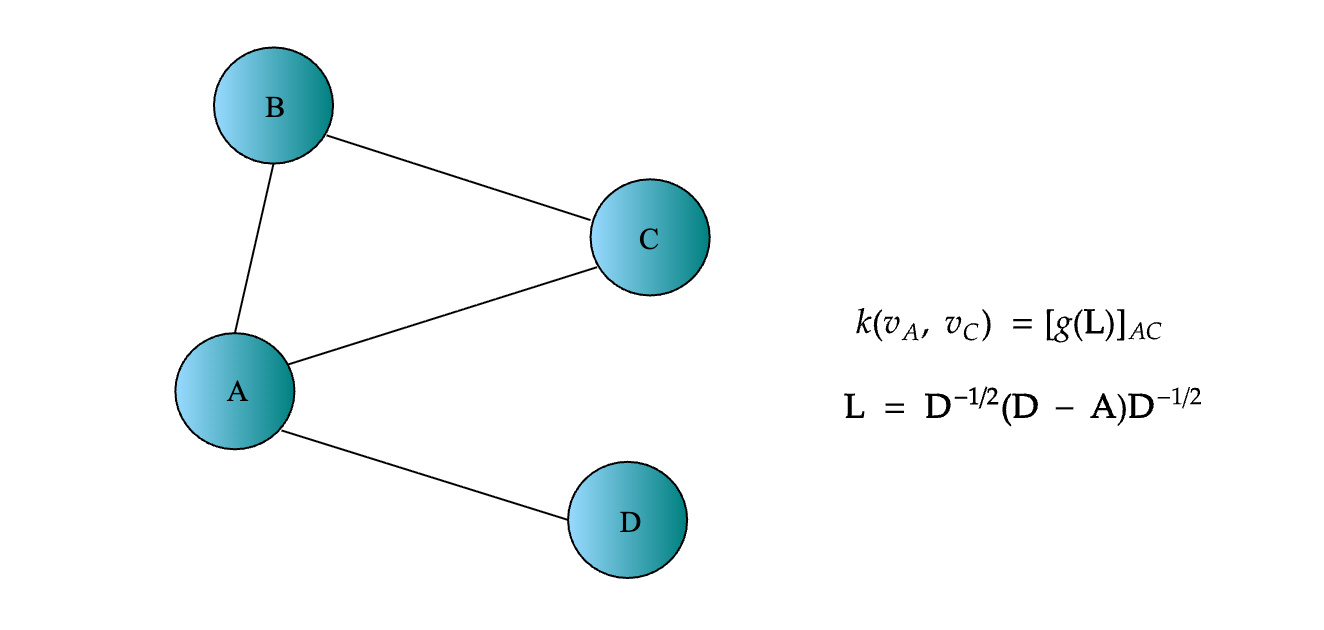

This kernel follows a slightly different implementation. Recall we are not using node features, so nodes are identified by their indices, and selecting the covariance between only the training nodes is carried out using the `gather` function in tensorflow. The input data to the model is therefore the indices of the training nodes, where the labels are the same as before.

In [10]:
# defining the inputs for graph kernel - indices of the nodes
train_x_id = tf.cast(tf.where(dataset.train_mask == True), tf.float64)
val_x_id = tf.cast(tf.where(dataset.val_mask == True), tf.float64)
test_x_id = tf.cast(tf.where(dataset.test_mask == True), tf.float64)

In [11]:
class GraphKernel(gpflow.kernels.Kernel):
    def __init__(self):
        super().__init__(active_dims=None)
        self.L = tf.convert_to_tensor(L, dtype=tf.float64)
        self.alpha = gpflow.Parameter(1.0, transform=positive())
        self.variance = gpflow.Parameter(1.0, transform=positive())

    def K(self, X, X2 = None):
        X = tf.reshape(tf.cast(X, tf.int32), [-1])
        X2 = tf.reshape(tf.cast(X2, tf.int32), [-1]) if X2 is not None else X
        # define kernel over the full graph
        GL = self.variance * tf.linalg.inv(tf.eye(self.L.shape[0], dtype=self.L.dtype) + self.alpha * self.L)
        # gather the sub-matrix corresponding to the training nodes
        return tf.gather(tf.gather(GL, X), X2, axis=1)

    # required method for gpflow kernels
    def K_diag(self, X):
        return tf.linalg.diag_part(self.K(X))

In [12]:
kernel = GraphKernel()
# note, input data is the indices of the training nodes, not the node features
data = (train_x_id, train_y.reshape(-1,1))

# the rest are the same as previous model
invlink = gpflow.likelihoods.RobustMax(num_classes)
likelihood = gpflow.likelihoods.MultiClass(
    num_classes, invlink=invlink
)
model = gpflow.models.VGP(
    data=data,
    kernel=kernel,
    likelihood=likelihood,
    num_latent_gps=num_classes
)
print_summary(model, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,1.0
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[0., 0., 0...."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[1., 0., 0...."


In [13]:
def step_callback(step, variables=None, values=None):
    pred = model.predict_y(val_x_id)[0]
    pred_class = tf.argmax(pred, axis=1)
    val_acc = tf.reduce_sum(tf.cast(pred_class == val_y, tf.float64)).numpy()/len(val_y)
    print(f"Epoch {step}, ELBo = {model.elbo().numpy():.3f}, Val Acc = {val_acc}")
    if step % 10 == 0:
        print_summary(model, fmt="notebook")

optimize_tf(model, step_callback, lr=0.1, num_epoch=100)

Epoch 0, ELBo = -996.174, Val Acc = 0.656


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,1.0
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.9999999999772295
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-0.09999821, -0.0999982, -0.09999821..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[9.00001917e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 1, ELBo = -1015.333, Val Acc = 0.658
Epoch 2, ELBo = -869.939, Val Acc = 0.664
Epoch 3, ELBo = -893.372, Val Acc = 0.664
Epoch 4, ELBo = -878.262, Val Acc = 0.664
Epoch 5, ELBo = -803.402, Val Acc = 0.662
Epoch 6, ELBo = -762.445, Val Acc = 0.666
Epoch 7, ELBo = -767.645, Val Acc = 0.666
Epoch 8, ELBo = -752.893, Val Acc = 0.666
Epoch 9, ELBo = -699.180, Val Acc = 0.666
Epoch 10, ELBo = -642.956, Val Acc = 0.666


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,1.68467
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.47352
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-0.50005139, -0.4984927, -0.49905593..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[0.83956255, 0., 0...."


Epoch 11, ELBo = -612.830, Val Acc = 0.668
Epoch 12, ELBo = -596.144, Val Acc = 0.668
Epoch 13, ELBo = -565.843, Val Acc = 0.668
Epoch 14, ELBo = -522.265, Val Acc = 0.668
Epoch 15, ELBo = -485.793, Val Acc = 0.668
Epoch 16, ELBo = -464.508, Val Acc = 0.668
Epoch 17, ELBo = -450.074, Val Acc = 0.674
Epoch 18, ELBo = -436.550, Val Acc = 0.674
Epoch 19, ELBo = -427.646, Val Acc = 0.674
Epoch 20, ELBo = -431.364, Val Acc = 0.674


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,2.61768
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,2.26928
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-0.23742737, -0.23524692, -0.23619941..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[7.99821889e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 21, ELBo = -446.585, Val Acc = 0.678
Epoch 22, ELBo = -462.856, Val Acc = 0.684
Epoch 23, ELBo = -469.686, Val Acc = 0.684
Epoch 24, ELBo = -465.298, Val Acc = 0.684
Epoch 25, ELBo = -456.567, Val Acc = 0.688
Epoch 26, ELBo = -448.888, Val Acc = 0.688
Epoch 27, ELBo = -441.952, Val Acc = 0.69
Epoch 28, ELBo = -434.331, Val Acc = 0.69
Epoch 29, ELBo = -427.117, Val Acc = 0.69
Epoch 30, ELBo = -422.731, Val Acc = 0.69


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,3.5063
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,3.01769
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-0.1733956, -0.17039077, -0.17170588..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[7.72300810e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 31, ELBo = -421.191, Val Acc = 0.69
Epoch 32, ELBo = -420.227, Val Acc = 0.69
Epoch 33, ELBo = -418.661, Val Acc = 0.69
Epoch 34, ELBo = -417.318, Val Acc = 0.688
Epoch 35, ELBo = -417.167, Val Acc = 0.688
Epoch 36, ELBo = -417.564, Val Acc = 0.688
Epoch 37, ELBo = -416.953, Val Acc = 0.688
Epoch 38, ELBo = -414.877, Val Acc = 0.688
Epoch 39, ELBo = -412.274, Val Acc = 0.688
Epoch 40, ELBo = -409.893, Val Acc = 0.688


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,4.41953
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,3.7801
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-3.48058077e-01, -3.41680901e-01, -3.45085864e-01..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[7.72301469e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 41, ELBo = -407.428, Val Acc = 0.688
Epoch 42, ELBo = -404.692, Val Acc = 0.688
Epoch 43, ELBo = -402.613, Val Acc = 0.694
Epoch 44, ELBo = -401.977, Val Acc = 0.694
Epoch 45, ELBo = -402.226, Val Acc = 0.696
Epoch 46, ELBo = -402.514, Val Acc = 0.696
Epoch 47, ELBo = -402.893, Val Acc = 0.696
Epoch 48, ELBo = -403.469, Val Acc = 0.696
Epoch 49, ELBo = -403.735, Val Acc = 0.694
Epoch 50, ELBo = -403.211, Val Acc = 0.694


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,5.37685
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,4.59093
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-0.2637821, -0.25509303, -0.25978574..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[7.44796768e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 51, ELBo = -402.137, Val Acc = 0.694
Epoch 52, ELBo = -401.020, Val Acc = 0.692
Epoch 53, ELBo = -399.994, Val Acc = 0.692
Epoch 54, ELBo = -398.992, Val Acc = 0.692
Epoch 55, ELBo = -398.168, Val Acc = 0.692
Epoch 56, ELBo = -397.741, Val Acc = 0.692
Epoch 57, ELBo = -397.603, Val Acc = 0.692
Epoch 58, ELBo = -397.483, Val Acc = 0.692
Epoch 59, ELBo = -397.324, Val Acc = 0.694
Epoch 60, ELBo = -397.180, Val Acc = 0.694


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,6.2764
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,5.3518
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-0.30580482, -0.29502254, -0.30111984..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[7.61625873e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 61, ELBo = -396.977, Val Acc = 0.694
Epoch 62, ELBo = -396.617, Val Acc = 0.694
Epoch 63, ELBo = -396.172, Val Acc = 0.694
Epoch 64, ELBo = -395.757, Val Acc = 0.694
Epoch 65, ELBo = -395.396, Val Acc = 0.692
Epoch 66, ELBo = -395.077, Val Acc = 0.694
Epoch 67, ELBo = -394.830, Val Acc = 0.694
Epoch 68, ELBo = -394.669, Val Acc = 0.694
Epoch 69, ELBo = -394.541, Val Acc = 0.694
Epoch 70, ELBo = -394.392, Val Acc = 0.694


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,7.12221
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,6.06576
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-0.2713588, -0.25996328, -0.26686525..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[7.71646513e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 71, ELBo = -394.215, Val Acc = 0.692
Epoch 72, ELBo = -394.009, Val Acc = 0.692
Epoch 73, ELBo = -393.761, Val Acc = 0.692
Epoch 74, ELBo = -393.481, Val Acc = 0.692
Epoch 75, ELBo = -393.202, Val Acc = 0.692
Epoch 76, ELBo = -392.944, Val Acc = 0.694
Epoch 77, ELBo = -392.708, Val Acc = 0.694
Epoch 78, ELBo = -392.504, Val Acc = 0.696
Epoch 79, ELBo = -392.334, Val Acc = 0.696
Epoch 80, ELBo = -392.183, Val Acc = 0.696


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,7.90284
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,6.72428
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-0.2852501, -0.27127736, -0.27953961..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[7.64818135e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 81, ELBo = -392.034, Val Acc = 0.696
Epoch 82, ELBo = -391.881, Val Acc = 0.696
Epoch 83, ELBo = -391.719, Val Acc = 0.696
Epoch 84, ELBo = -391.545, Val Acc = 0.696
Epoch 85, ELBo = -391.362, Val Acc = 0.696
Epoch 86, ELBo = -391.182, Val Acc = 0.696
Epoch 87, ELBo = -391.010, Val Acc = 0.696
Epoch 88, ELBo = -390.845, Val Acc = 0.696
Epoch 89, ELBo = -390.688, Val Acc = 0.696
Epoch 90, ELBo = -390.537, Val Acc = 0.698


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,8.64993
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,7.35756
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-0.28552428, -0.26966428, -0.27942912..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[7.62430011e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 91, ELBo = -390.390, Val Acc = 0.698
Epoch 92, ELBo = -390.241, Val Acc = 0.698
Epoch 93, ELBo = -390.090, Val Acc = 0.698
Epoch 94, ELBo = -389.937, Val Acc = 0.698
Epoch 95, ELBo = -389.784, Val Acc = 0.698
Epoch 96, ELBo = -389.631, Val Acc = 0.698
Epoch 97, ELBo = -389.483, Val Acc = 0.698
Epoch 98, ELBo = -389.339, Val Acc = 0.698
Epoch 99, ELBo = -389.199, Val Acc = 0.698


In [14]:
# final predict
pred = model.predict_y(val_x_id)
pred_class = tf.argmax(pred[0], axis=1)
tf.reduce_sum(tf.cast(pred_class == val_y, tf.float64)).numpy()/len(val_y)

0.698

- We previously saw this function $(\mathbf{I} + \alpha \mathbf{L})^{-1}$ in Lab 2: what was the purpose of this function in the previous lab?

It is a low-pass, supressing high frequencies.

- How does this compare to the standard GP, and what does this tell you about the graph and node features?

It defines similarity based on graph connectivity, not node features.

Two nodes are considered similar if they are well connected in the graph.

## Graph GPs

Much like a GNN, a graph GP should utilize both the node features and the graph.

We note the formula of the standard GP

$$
\mathbf{f} \sim N(0, \mathbf{K})
$$

is a model on the node features already. To incorporate graph information into a model $\mathbf{f}$, we can apply the transformation

$$
g(\mathbf{L}) \mathbf{f}.
$$

This is equivalent to applying graph filtering to a signal, with the signal being modeled as a GP. We treat the two terms together and the prior can be derived as

$$
g(\mathbf{L})\mathbf{f} \sim N(0, g(\mathbf{L})\mathbf{K}g(\mathbf{L})^\top)
$$

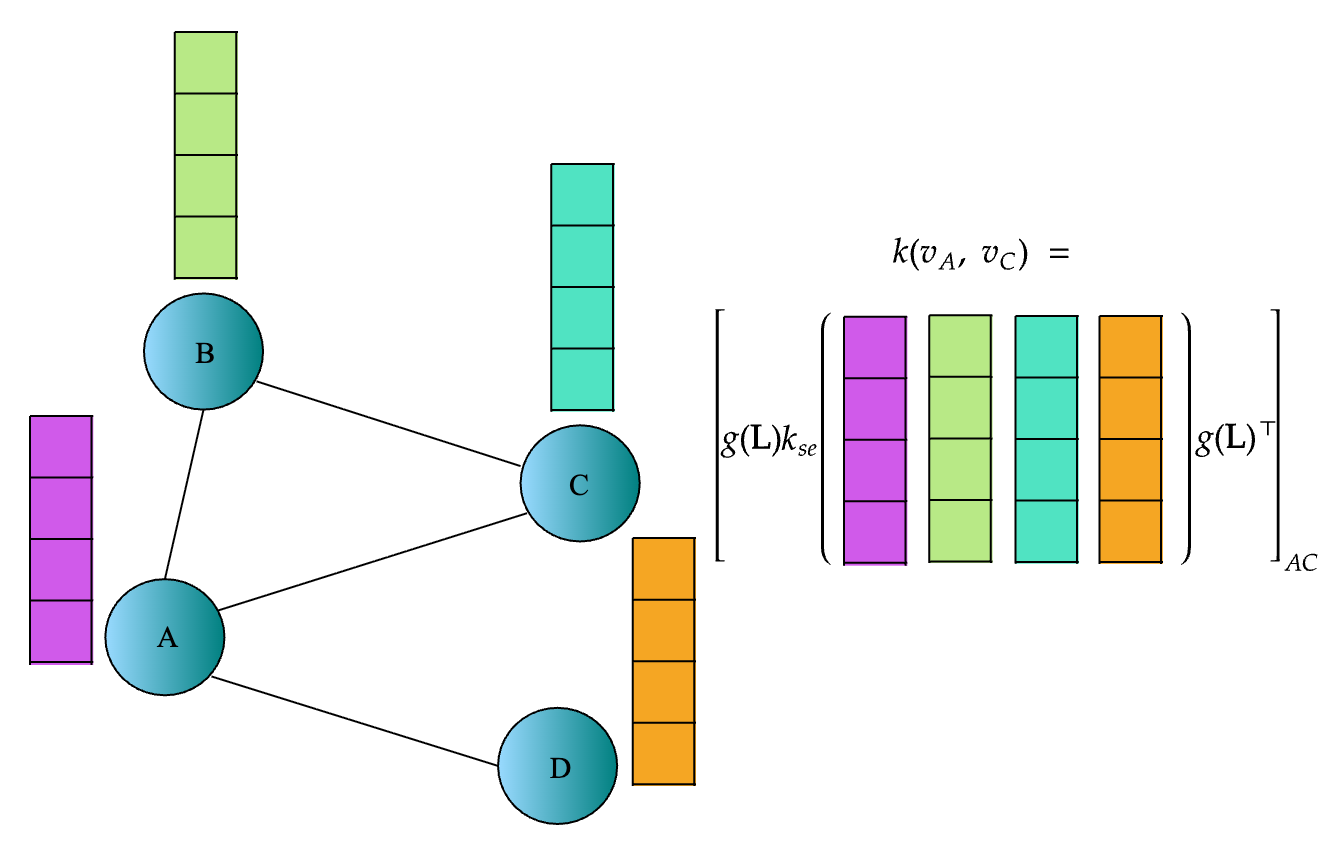

Note, implementation of this kernel also requires defining the covariance for the whole graph and taking the subset corresponding to the training nodes, therefore we utilize the same `gather` function from the previous graph only kernel.

In [15]:
class GraphGPKernel(gpflow.kernels.Kernel):
    def __init__(self, lengthscales = 1., variance = 1.):
        super().__init__(active_dims=None)
        self.base_kernel = gpflow.kernels.SquaredExponential(lengthscales = lengthscales, variance = variance)
        self.base_data = dataset.data.x
        self.L = tf.convert_to_tensor(L, dtype=tf.float64)
        self.alpha = gpflow.Parameter(1.0, transform=positive())

    def K(self, X, X2 = None):
        X = tf.reshape(tf.cast(X, tf.int32), [-1])
        X2 = tf.reshape(tf.cast(X2, tf.int32), [-1]) if X2 is not None else X
        GL = tf.linalg.inv(tf.eye(self.L.shape[0], dtype=self.L.dtype) + self.alpha * self.L)
        base_covar = self.base_kernel(self.base_data)
        graph_covar = GL @ base_covar @ tf.transpose(GL)
        return tf.gather(tf.gather(graph_covar, X), X2, axis=1)

    def K_diag(self, X):
        return tf.linalg.diag_part(self.K(X))

In [16]:
kernel = GraphGPKernel()
data = (train_x_id, train_y.reshape(-1,1))

# the rest are the same as previous case
invlink = gpflow.likelihoods.RobustMax(num_classes)
likelihood = gpflow.likelihoods.MultiClass(
    num_classes, invlink=invlink
)

model = gpflow.models.VGP(
    data=data,
    kernel=kernel,
    likelihood=likelihood,
    num_latent_gps=num_classes
)
print_summary(model, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.base_kernel.variance,Parameter,Softplus,,True,(),float64,1.0
VGP.kernel.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,1.0
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[0., 0., 0...."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[1., 0., 0...."


In [17]:
# here we will evaluate on both the validation and test sets
def step_callback(step, variables=None, values=None):
    pred = model.predict_y(val_x_id)[0]
    pred_class = tf.argmax(pred, axis=1)
    val_acc = tf.reduce_sum(tf.cast(pred_class == val_y, tf.float64)).numpy()/len(val_y)
    pred = model.predict_y(test_x_id)[0]
    pred_class = tf.argmax(pred, axis=1)
    test_acc = tf.reduce_sum(tf.cast(pred_class == test_y, tf.float64)).numpy()/len(test_y)
    print(f"Epoch {step}, ELBo = {model.elbo().numpy():.3f}, Val Acc = {val_acc}, Test Acc = {test_acc}")
    if step % 10 == 0:
        print_summary(model, fmt="notebook")

optimize_tf(model, step_callback, lr=0.1, num_epoch=100)

Epoch 0, ELBo = -1166.585, Val Acc = 0.622, Test Acc = 0.639


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.base_kernel.variance,Parameter,Softplus,,True,(),float64,0.9999999999860182
VGP.kernel.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,1.0
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-0.09999824, -0.09999822, -0.09999819..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[0.90000192, 0., 0...."


Epoch 1, ELBo = -940.248, Val Acc = 0.642, Test Acc = 0.651
Epoch 2, ELBo = -939.671, Val Acc = 0.642, Test Acc = 0.65
Epoch 3, ELBo = -949.354, Val Acc = 0.644, Test Acc = 0.663
Epoch 4, ELBo = -864.485, Val Acc = 0.65, Test Acc = 0.665
Epoch 5, ELBo = -786.797, Val Acc = 0.66, Test Acc = 0.677
Epoch 6, ELBo = -773.878, Val Acc = 0.676, Test Acc = 0.681
Epoch 7, ELBo = -783.840, Val Acc = 0.672, Test Acc = 0.682
Epoch 8, ELBo = -753.147, Val Acc = 0.674, Test Acc = 0.682
Epoch 9, ELBo = -686.232, Val Acc = 0.678, Test Acc = 0.685
Epoch 10, ELBo = -627.951, Val Acc = 0.682, Test Acc = 0.685


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.base_kernel.variance,Parameter,Softplus,,True,(),float64,1.5694
VGP.kernel.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.8189814986093631
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,1.65271
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-0.5113862, -0.50095641, -0.49854619..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[8.41545341e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 11, ELBo = -600.525, Val Acc = 0.684, Test Acc = 0.684
Epoch 12, ELBo = -583.917, Val Acc = 0.682, Test Acc = 0.684
Epoch 13, ELBo = -551.886, Val Acc = 0.682, Test Acc = 0.686
Epoch 14, ELBo = -506.857, Val Acc = 0.682, Test Acc = 0.689
Epoch 15, ELBo = -467.630, Val Acc = 0.682, Test Acc = 0.689
Epoch 16, ELBo = -443.427, Val Acc = 0.68, Test Acc = 0.689
Epoch 17, ELBo = -431.636, Val Acc = 0.682, Test Acc = 0.689
Epoch 18, ELBo = -424.438, Val Acc = 0.676, Test Acc = 0.691
Epoch 19, ELBo = -418.771, Val Acc = 0.67, Test Acc = 0.689
Epoch 20, ELBo = -419.252, Val Acc = 0.672, Test Acc = 0.691


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.base_kernel.variance,Parameter,Softplus,,True,(),float64,2.45133
VGP.kernel.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.01756
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,2.57848
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-0.23964599, -0.23065262, -0.2334686..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[0.80121384, 0., 0...."


Epoch 21, ELBo = -428.379, Val Acc = 0.672, Test Acc = 0.69
Epoch 22, ELBo = -440.875, Val Acc = 0.668, Test Acc = 0.69
Epoch 23, ELBo = -447.890, Val Acc = 0.668, Test Acc = 0.691
Epoch 24, ELBo = -444.426, Val Acc = 0.666, Test Acc = 0.697
Epoch 25, ELBo = -433.831, Val Acc = 0.668, Test Acc = 0.698
Epoch 26, ELBo = -422.591, Val Acc = 0.666, Test Acc = 0.696
Epoch 27, ELBo = -413.901, Val Acc = 0.67, Test Acc = 0.697
Epoch 28, ELBo = -407.426, Val Acc = 0.668, Test Acc = 0.698
Epoch 29, ELBo = -401.446, Val Acc = 0.668, Test Acc = 0.699
Epoch 30, ELBo = -395.609, Val Acc = 0.666, Test Acc = 0.698


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.base_kernel.variance,Parameter,Softplus,,True,(),float64,3.29984
VGP.kernel.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.16873
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,3.46168
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-0.18809955, -0.16920666, -0.15265472..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[7.78301716e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 31, ELBo = -390.881, Val Acc = 0.668, Test Acc = 0.7
Epoch 32, ELBo = -388.172, Val Acc = 0.668, Test Acc = 0.7
Epoch 33, ELBo = -386.820, Val Acc = 0.668, Test Acc = 0.699
Epoch 34, ELBo = -385.452, Val Acc = 0.668, Test Acc = 0.695
Epoch 35, ELBo = -383.705, Val Acc = 0.664, Test Acc = 0.695
Epoch 36, ELBo = -381.889, Val Acc = 0.666, Test Acc = 0.696
Epoch 37, ELBo = -379.889, Val Acc = 0.674, Test Acc = 0.711
Epoch 38, ELBo = -377.013, Val Acc = 0.686, Test Acc = 0.725
Epoch 39, ELBo = -372.799, Val Acc = 0.702, Test Acc = 0.74
Epoch 40, ELBo = -367.219, Val Acc = 0.714, Test Acc = 0.762


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.base_kernel.variance,Parameter,Softplus,,True,(),float64,4.24365
VGP.kernel.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.58988
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,4.39572
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-0.39272742, -0.30911207, -0.28752255..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[7.79417312e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 41, ELBo = -360.411, Val Acc = 0.716, Test Acc = 0.772
Epoch 42, ELBo = -352.847, Val Acc = 0.73, Test Acc = 0.778
Epoch 43, ELBo = -345.157, Val Acc = 0.736, Test Acc = 0.781
Epoch 44, ELBo = -337.394, Val Acc = 0.746, Test Acc = 0.786
Epoch 45, ELBo = -331.346, Val Acc = 0.758, Test Acc = 0.8
Epoch 46, ELBo = -330.192, Val Acc = 0.768, Test Acc = 0.796
Epoch 47, ELBo = -331.081, Val Acc = 0.764, Test Acc = 0.807
Epoch 48, ELBo = -319.892, Val Acc = 0.768, Test Acc = 0.795
Epoch 49, ELBo = -318.529, Val Acc = 0.78, Test Acc = 0.826
Epoch 50, ELBo = -305.871, Val Acc = 0.784, Test Acc = 0.825


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.base_kernel.variance,Parameter,Softplus,,True,(),float64,5.27963
VGP.kernel.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,2.72756
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,5.34103
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,140
VGP.q_mu,Parameter,Identity,,True,"(140, 7)",float64,"[[-3.19963177e-01, -1.39335723e-01, 4.43420935e-02..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 140, 140)",float64,"[[[6.18573765e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 51, ELBo = -302.810, Val Acc = 0.774, Test Acc = 0.805


KeyboardInterrupt: 

In [18]:
# final prediction
pred = model.predict_y(val_x_id)
pred_class = tf.argmax(pred[0], axis=1)
print(f'Val Acc = {tf.reduce_sum(tf.cast(pred_class == val_y, tf.float64)).numpy()/len(val_y)}')

pred = model.predict_y(test_x_id)
pred_class = tf.argmax(pred[0], axis=1)
print(f'Test Acc = {tf.reduce_sum(tf.cast(pred_class == test_y, tf.float64)).numpy()/len(test_y)}')

Val Acc = 0.782
Test Acc = 0.829


- How do the 3 GPs in this lab compare to the three models introduced in Lab 3? Which model performed the best and why?

The third one combines both node features (via the base kernel K) and graph structure (via g(L)).

- Can you interpret what $g(\mathbf{L})\mathbf{f}$ is doing? What's the connection between signal processing and kernel functions?

it acts as a spectral filter — it modifies the signal f in the frequency domain and smooth the signal

**[Task]** Another advantage of GPs is that they are self-contained - the training data is used to both infer the hyperparameters and make predictions on the test points. Validation sets, which are usually used to tune GNNs, are not required for a GP. As a result, it is common to include the validation set as additional training data as they are unused. Your task is to train the graph GP on a training data consisting of both the training and validation sets and report the test predictive accuracy.

In [20]:
# Combine training and validation data for training
combined_train_x_id = tf.concat([train_x_id, val_x_id], axis=0)
combined_train_y = tf.concat([train_y, val_y], axis=0)

# Update the data for the model with the combined training and validation sets
data_combined = (combined_train_x_id, tf.reshape(combined_train_y, (-1,1)))

# Re-initialize the model with the combined data
model_combined = gpflow.models.VGP(
    data=data_combined,
    kernel=GraphGPKernel(),
    likelihood=likelihood,
    num_latent_gps=num_classes
)

print_summary(model_combined, fmt="notebook")

# Define a step callback for the combined training data
def step_callback_combined(step, variables=None, values=None):
    pred = model_combined.predict_y(test_x_id)[0]
    pred_class = tf.argmax(pred, axis=1)
    test_acc = tf.reduce_sum(tf.cast(pred_class == test_y, tf.float64)).numpy()/len(test_y)
    print(f"Epoch {step}, ELBo = {model_combined.elbo().numpy():.3f}, Test Acc = {test_acc}")
    if step % 10 == 0:
        print_summary(model_combined, fmt="notebook")

# Optimize the model with the combined training data
optimize_tf(model_combined, step_callback_combined, lr=0.1, num_epoch=100)

# Final prediction on the test set
pred = model_combined.predict_y(test_x_id)
pred_class = tf.argmax(pred[0], axis=1)
print(f'Test Acc = {tf.reduce_sum(tf.cast(pred_class == test_y, tf.float64)).numpy()/len(test_y)}')

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.base_kernel.variance,Parameter,Softplus,,True,(),float64,1.0
VGP.kernel.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,1.0
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,640
VGP.q_mu,Parameter,Identity,,True,"(640, 7)",float64,"[[0., 0., 0...."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 640, 640)",float64,"[[[1., 0., 0...."


Epoch 0, ELBo = -8081.565, Test Acc = 0.698


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.base_kernel.variance,Parameter,Softplus,,True,(),float64,0.9999999999636598
VGP.kernel.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,1.0
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,640
VGP.q_mu,Parameter,Identity,,True,"(640, 7)",float64,"[[-0.09999858, -0.09999858, -0.09999851..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 640, 640)",float64,"[[[0.90000179, 0., 0...."


Epoch 1, ELBo = -5319.477, Test Acc = 0.794
Epoch 2, ELBo = -5459.815, Test Acc = 0.793
Epoch 3, ELBo = -6346.063, Test Acc = 0.792
Epoch 4, ELBo = -5459.110, Test Acc = 0.802
Epoch 5, ELBo = -3986.238, Test Acc = 0.803
Epoch 6, ELBo = -3732.422, Test Acc = 0.806
Epoch 7, ELBo = -4398.198, Test Acc = 0.811
Epoch 8, ELBo = -4414.769, Test Acc = 0.81
Epoch 9, ELBo = -3610.725, Test Acc = 0.81
Epoch 10, ELBo = -2874.312, Test Acc = 0.811


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.base_kernel.variance,Parameter,Softplus,,True,(),float64,1.31637
VGP.kernel.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.7084384121144894
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,1.61378
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,640
VGP.q_mu,Parameter,Identity,,True,"(640, 7)",float64,"[[-0.74416642, -0.72551938, -0.73557531..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 640, 640)",float64,"[[[0.8284902, 0., 0...."


Epoch 11, ELBo = -2834.652, Test Acc = 0.811
Epoch 12, ELBo = -3029.232, Test Acc = 0.807
Epoch 13, ELBo = -2868.934, Test Acc = 0.809
Epoch 14, ELBo = -2432.524, Test Acc = 0.808
Epoch 15, ELBo = -2103.250, Test Acc = 0.811
Epoch 16, ELBo = -2033.217, Test Acc = 0.812
Epoch 17, ELBo = -2080.106, Test Acc = 0.813
Epoch 18, ELBo = -2057.727, Test Acc = 0.814
Epoch 19, ELBo = -1940.720, Test Acc = 0.815
Epoch 20, ELBo = -1837.246, Test Acc = 0.815


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.base_kernel.variance,Parameter,Softplus,,True,(),float64,1.9391
VGP.kernel.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.6651889546844628
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,2.50914
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,640
VGP.q_mu,Parameter,Identity,,True,"(640, 7)",float64,"[[-0.30430634, -0.27668049, -0.29336172..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 640, 640)",float64,"[[[0.83388132, 0., 0...."


Epoch 21, ELBo = -1826.223, Test Acc = 0.816
Epoch 22, ELBo = -1879.465, Test Acc = 0.817
Epoch 23, ELBo = -1907.772, Test Acc = 0.817
Epoch 24, ELBo = -1864.222, Test Acc = 0.818
Epoch 25, ELBo = -1786.061, Test Acc = 0.818
Epoch 26, ELBo = -1724.909, Test Acc = 0.818
Epoch 27, ELBo = -1689.217, Test Acc = 0.816
Epoch 28, ELBo = -1657.122, Test Acc = 0.816
Epoch 29, ELBo = -1613.236, Test Acc = 0.816
Epoch 30, ELBo = -1563.679, Test Acc = 0.813


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.base_kernel.variance,Parameter,Softplus,,True,(),float64,2.58205
VGP.kernel.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.6943574655050924
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,3.3048
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,640
VGP.q_mu,Parameter,Identity,,True,"(640, 7)",float64,"[[-0.12631433, -0.10350011, -0.14548248..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 640, 640)",float64,"[[[8.00555658e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 31, ELBo = -1524.567, Test Acc = 0.813
Epoch 32, ELBo = -1501.972, Test Acc = 0.813
Epoch 33, ELBo = -1487.609, Test Acc = 0.813
Epoch 34, ELBo = -1471.429, Test Acc = 0.815
Epoch 35, ELBo = -1451.786, Test Acc = 0.814
Epoch 36, ELBo = -1433.354, Test Acc = 0.815
Epoch 37, ELBo = -1418.852, Test Acc = 0.816
Epoch 38, ELBo = -1405.546, Test Acc = 0.817
Epoch 39, ELBo = -1389.141, Test Acc = 0.817
Epoch 40, ELBo = -1369.706, Test Acc = 0.817


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.base_kernel.variance,Parameter,Softplus,,True,(),float64,3.3284
VGP.kernel.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.835057074898962
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,4.08496
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,640
VGP.q_mu,Parameter,Identity,,True,"(640, 7)",float64,"[[-0.43543325, -0.37508439, -0.43159547..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 640, 640)",float64,"[[[8.29383866e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 41, ELBo = -1350.902, Test Acc = 0.817
Epoch 42, ELBo = -1335.386, Test Acc = 0.82
Epoch 43, ELBo = -1321.499, Test Acc = 0.82
Epoch 44, ELBo = -1307.645, Test Acc = 0.82
Epoch 45, ELBo = -1294.908, Test Acc = 0.818
Epoch 46, ELBo = -1283.972, Test Acc = 0.822
Epoch 47, ELBo = -1273.458, Test Acc = 0.819
Epoch 48, ELBo = -1260.748, Test Acc = 0.819
Epoch 49, ELBo = -1244.815, Test Acc = 0.823
Epoch 50, ELBo = -1227.591, Test Acc = 0.825


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.base_kernel.variance,Parameter,Softplus,,True,(),float64,4.18252
VGP.kernel.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.45813
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,4.90481
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,640
VGP.q_mu,Parameter,Identity,,True,"(640, 7)",float64,"[[-0.3071988, -0.21999726, -0.26965794..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 640, 640)",float64,"[[[7.90177944e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 51, ELBo = -1212.423, Test Acc = 0.831
Epoch 52, ELBo = -1206.350, Test Acc = 0.833
Epoch 53, ELBo = -1173.844, Test Acc = 0.836
Epoch 54, ELBo = -1120.731, Test Acc = 0.839
Epoch 55, ELBo = -1092.786, Test Acc = 0.851
Epoch 56, ELBo = -1045.502, Test Acc = 0.853
Epoch 57, ELBo = -1005.985, Test Acc = 0.859
Epoch 58, ELBo = -980.132, Test Acc = 0.86
Epoch 59, ELBo = -941.992, Test Acc = 0.86
Epoch 60, ELBo = -929.126, Test Acc = 0.861


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.base_kernel.variance,Parameter,Softplus,,True,(),float64,4.86908
VGP.kernel.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,2.75602
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,5.54174
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,640
VGP.q_mu,Parameter,Identity,,True,"(640, 7)",float64,"[[-3.06103115e-01, -1.00646470e-01, 4.89077293e-02..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 640, 640)",float64,"[[[6.65879247e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 61, ELBo = -893.852, Test Acc = 0.871
Epoch 62, ELBo = -881.677, Test Acc = 0.863
Epoch 63, ELBo = -858.834, Test Acc = 0.868
Epoch 64, ELBo = -843.843, Test Acc = 0.864
Epoch 65, ELBo = -838.396, Test Acc = 0.87
Epoch 66, ELBo = -815.928, Test Acc = 0.863
Epoch 67, ELBo = -808.997, Test Acc = 0.871
Epoch 68, ELBo = -792.387, Test Acc = 0.869
Epoch 69, ELBo = -783.179, Test Acc = 0.867
Epoch 70, ELBo = -770.399, Test Acc = 0.864


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.base_kernel.variance,Parameter,Softplus,,True,(),float64,5.27794
VGP.kernel.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,3.78342
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,5.90964
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,640
VGP.q_mu,Parameter,Identity,,True,"(640, 7)",float64,"[[-1.99922650e-01, 3.58305643e-03, 1.43794661e-01..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 640, 640)",float64,"[[[5.24256389e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 71, ELBo = -764.325, Test Acc = 0.874
Epoch 72, ELBo = -755.415, Test Acc = 0.869
Epoch 73, ELBo = -747.629, Test Acc = 0.87
Epoch 74, ELBo = -745.520, Test Acc = 0.873
Epoch 75, ELBo = -740.230, Test Acc = 0.873
Epoch 76, ELBo = -735.770, Test Acc = 0.872
Epoch 77, ELBo = -730.123, Test Acc = 0.868
Epoch 78, ELBo = -722.034, Test Acc = 0.874
Epoch 79, ELBo = -725.108, Test Acc = 0.871
Epoch 80, ELBo = -720.309, Test Acc = 0.873


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.base_kernel.variance,Parameter,Softplus,,True,(),float64,5.64084
VGP.kernel.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,4.43032
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,6.1731
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,640
VGP.q_mu,Parameter,Identity,,True,"(640, 7)",float64,"[[-0.16443746, 0.01884102, 0.16025047..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 640, 640)",float64,"[[[4.20229132e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 81, ELBo = -718.377, Test Acc = 0.872
Epoch 82, ELBo = -712.896, Test Acc = 0.868
Epoch 83, ELBo = -712.626, Test Acc = 0.869
Epoch 84, ELBo = -708.743, Test Acc = 0.868
Epoch 85, ELBo = -704.125, Test Acc = 0.872
Epoch 86, ELBo = -704.024, Test Acc = 0.869
Epoch 87, ELBo = -704.261, Test Acc = 0.873
Epoch 88, ELBo = -709.043, Test Acc = 0.867
Epoch 89, ELBo = -713.093, Test Acc = 0.869
Epoch 90, ELBo = -704.781, Test Acc = 0.866


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.base_kernel.variance,Parameter,Softplus,,True,(),float64,6.07975
VGP.kernel.base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,4.86198
VGP.kernel.alpha,Parameter,Softplus,,True,(),float64,6.40495
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
VGP.num_data,Parameter,Identity,,False,(),int32,640
VGP.q_mu,Parameter,Identity,,True,"(640, 7)",float64,"[[-1.20126822e-01, 5.33414664e-02, 1.90696011e-01..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(7, 640, 640)",float64,"[[[3.45590616e-01, 0.00000000e+00, 0.00000000e+00..."


Epoch 91, ELBo = -700.101, Test Acc = 0.873
Epoch 92, ELBo = -698.968, Test Acc = 0.876
Epoch 93, ELBo = -696.465, Test Acc = 0.868
Epoch 94, ELBo = -693.823, Test Acc = 0.874
Epoch 95, ELBo = -690.835, Test Acc = 0.876
Epoch 96, ELBo = -690.665, Test Acc = 0.867
Epoch 97, ELBo = -687.358, Test Acc = 0.873
Epoch 98, ELBo = -685.382, Test Acc = 0.875
Epoch 99, ELBo = -686.709, Test Acc = 0.868
Test Acc = 0.868


**[Optional]** If you are interested in more flexible GPs for node classification on graphs, you can look into the extension of spectral graph wavelets [here](https://arxiv.org/abs/2110.12752), which introduces kernels that consists of band-pass (as typical in wavelets) along with the low-pass we are currently using for handling more complex data and classification tasks. The work also includes methods of scalability to avoid the cubic complexity of computing the graph filters/kernels.

**[Checkpoint]** You are now done with this lab session. Please ask a lab demonstrator to evaluate your work.